In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import json

In [180]:
# Autoencoder architecture
input_img = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [181]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [138]:
def build_encoder(input_shape, filters=[16, 8, 8], kernel_sizes=[(3, 3), (3, 3), (3, 3)], activations=['relu', 'relu', 'relu']):
    input_img = Input(shape=input_shape)
    x = input_img
    for i in range(len(filters)):
        x = Conv2D(filters[i], kernel_sizes[i], activation=activations[i], padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = BatchNormalization()(x)
    encoded = x
    return Model(input_img, encoded)

def build_decoder(encoded_shape, filters=[8, 8, 16], kernel_sizes=[(3, 3), (3, 3), (3, 3)], activations=['relu', 'relu', 'relu']):
    input_encoded = Input(shape=encoded_shape)
    x = input_encoded
    for i in range(len(filters)):
        x = Conv2D(filters[i], kernel_sizes[i], activation=activations[i], padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_encoded, decoded)
        

In [139]:
def build_autoencoder(encoder, decoder):
    input_img = encoder.input
    output_img = decoder(encoder.output)
    return Model(input_img, output_img)

def compile_autoencoder(encoder, decoder, optimizer='adam', loss='mse'):
    autoencoder = build_autoencoder(encoder, decoder)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

In [182]:
autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [183]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_52 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 32, 32, 16)        0  

 conv2d_74 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 up_sampling2d_31 (UpSampli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_55 (Ba  (None, 64, 64, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_75 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 up_sampling2d_32 (UpSampli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 128, 128, 3)       867       
                                                                 
Total para

In [141]:
data_dir = "../StanfordCarDataset"
train_resized_dir = f"{data_dir}/resized_dataset_train"
test_resized_dir = f"{data_dir}/resized_dataset_test"
noisy_dataset_train_dir = f"{data_dir}/noisy_dataset_train"
noisy_dataset_test_dir = f"{data_dir}/noisy_dataset_test"

In [177]:
# Function to add noise to images
def add_noise(image, noise_factor=0.5):
    mean = 0
    var = 0.5
    sigma = var ** 0.9
    # scale = 8000
    # noise = np.random.normal(mean, sigma, image.shape)
    # noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    # Generate Gaussian noise with the same shape as the input images
    # if not isinstance(images, np.ndarray):
    #     images = np.array(images)
    noise = np.random.normal(loc=mean, scale=105, size=image.shape)
    # noisy_image = (image + noise_factor * noise)/255
    noisy_image = (image + noise)
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image

In [123]:
def plot_images(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i + 1}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

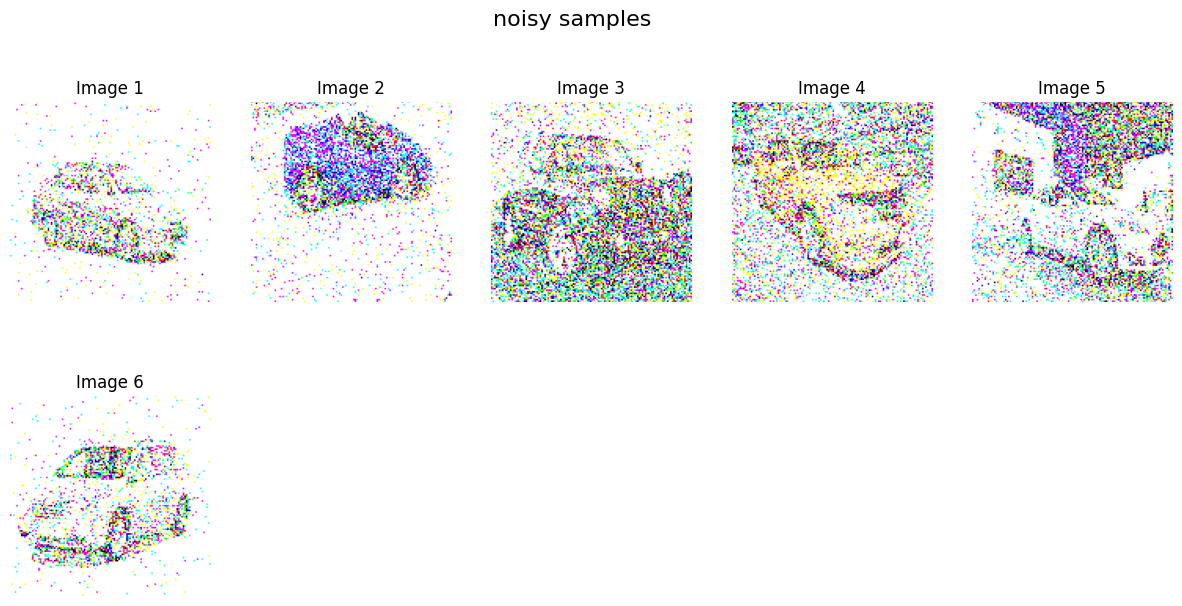

In [178]:
noisy_images = []
source_directory = f"{data_dir}/resized_dataset_test"
max = 5
count = 0
for filename in os.listdir(source_directory):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(source_directory, filename)
        img = cv2.imread(img_path)
        noisy_images.append(add_noise(img))

        if count >= max:
            break
        count +=1

images = np.array(noisy_images)
plot_images(images, "noisy samples")

In [179]:
def create_noisy_images_from_set(source_directory, noisy_directory, limit=-1):
    count = 0
    for filename in os.listdir(source_directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(source_directory, filename)
            img = cv2.imread(img_path)
            noisy_img = add_noise(img)
            noisy_img = noisy_img * 255
            noisy_img_path = os.path.join(noisy_directory, filename)
            cv2.imwrite(noisy_img_path, noisy_img)
            count+=1
            if limit > 0 and count >= limit:
                break
            

create_noisy_images_from_set(train_resized_dir, noisy_dataset_train_dir)
create_noisy_images_from_set(test_resized_dir, noisy_dataset_test_dir)

In [75]:
def fetch_images_as_nparray(directory, max_images=-1):
    np_images = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # if len(img.shape) == 2:  # Convert grayscale to RGB
                #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                np_images.append(img)
            
                count += 1
                if max_images > 0 and count >= max_images:
                    break
    return np.array(np_images)


In [184]:
max_train_images = 1000
max_validation_images = round(max_train_images*0.2)

x_train_noisy = fetch_images_as_nparray(noisy_dataset_train_dir, max_images=max_train_images)
x_test_noisy = fetch_images_as_nparray(noisy_dataset_test_dir, max_images=max_validation_images)
x_train = fetch_images_as_nparray(train_resized_dir, max_images=max_train_images)
x_test = fetch_images_as_nparray(test_resized_dir, max_images=max_validation_images)

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(x_train.shape)
print(x_test.shape)



(1000, 128, 128, 3)
(200, 128, 128, 3)
(1000, 128, 128, 3)
(200, 128, 128, 3)


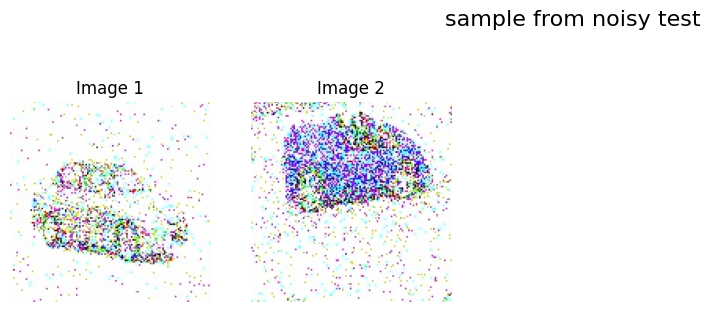

In [185]:
plot_images(x_test_noisy[0:2], "sample from noisy test")

In [186]:
x_train_noisy = x_train_noisy.astype('float32') / 255.0
x_train = x_train.astype('float32') / 255.0

# Create noisy and clean validation datasets
x_test_noisy = x_test_noisy.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(x_train.shape)
print(x_test_noisy.shape)
print(x_test.shape)

(1000, 128, 128, 3)
(200, 128, 128, 3)
(200, 128, 128, 3)


In [187]:
# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
8/8 [==============================] - 63s 5s/step - loss: 0.0729 - val_loss: 0.0855
Epoch 2/50
8/8 [==============================] - 27s 3s/step - loss: 0.0460 - val_loss: 0.0838
Epoch 3/50
8/8 [==============================] - 21s 3s/step - loss: 0.0366 - val_loss: 0.0859
Epoch 4/50
8/8 [==============================] - 25s 3s/step - loss: 0.0316 - val_loss: 0.0886
Epoch 5/50
8/8 [==============================] - 24s 3s/step - loss: 0.0288 - val_loss: 0.0883
Epoch 6/50
1/8 [==>...........................] - ETA: 18s - loss: 0.0281

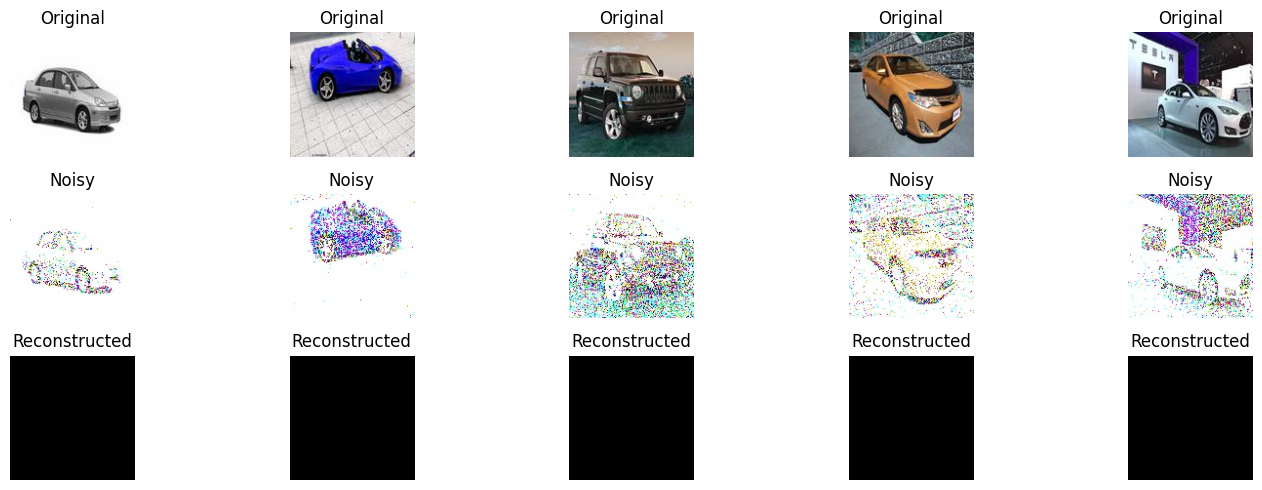

In [148]:
num_images = 5

normal_test_images = fetch_images_as_nparray(f"{data_dir}/resized_dataset_test", num_images)
plot_images(normal_test_images, "Original Images")
noisy_test_images = fetch_images_as_nparray(f"{data_dir}/noisy_dataset_test", num_images)
plot_images(noisy_test_images, "Noisy Test Images")
reconstructed_images = autoencoder.predict(noisy_test_images)
plot_images(reconstructed_images, "Reconstructed Images")

# plt.figure(figsize=(15, 5))
# for i in range(num_images):
#     # Original
#     plt.subplot(3, num_images, i + 1)
#     plt.imshow(normal_test_images[i], cmap='gray')
#     plt.title('Original')
#     plt.axis('off')

#     # Noisy
#     plt.subplot(3, num_images, i + 1 + num_images)
#     plt.imshow(noisy_test_images[i], cmap='gray')
#     plt.title('Noisy')
#     plt.axis('off')

#     # Reconstructed
#     plt.subplot(3, num_images, i + 1 + 2 * num_images)
#     plt.imshow(reconstructed_images[i], cmap='gray')
#     plt.title('Reconstructed')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [142]:
def train_autoencoder(autoencoder, epochs=50, batch_size=128):
    history = autoencoder.fit(x_train_noisy, x_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               shuffle=True,
                               validation_data=(x_test_noisy, x_test))
    return history

In [143]:
def plot_results(autoencoder, title="", n=2):
    decoded_imgs = autoencoder.predict(x_test_noisy[:n])
    plot_images(decoded_imgs)

In [147]:
hyperparameters_array = [
    {
        "input_shape": (128, 128, 3),
        "encoder_filters": [32, 16, 8],
        "decoder_filters": [8, 16, 32],
        "epochs": 100,
        "batch_size": 128
    },
    {
        "input_shape": (128, 128, 3),
        "encoder_filters": [64, 32, 16],
        "decoder_filters": [16, 32, 64],
        "epochs": 100,
        "batch_size": 256
    }
]

def train_and_plot(hyperparameters):
    encoder = build_encoder(hyperparameters["input_shape"], hyperparameters["encoder_filters"])
    decoder = build_decoder(encoder.output_shape[1:], hyperparameters["decoder_filters"])
    # autoencoder = Model(encoder.input, decoder(encoder.output))
    compile_autoencoder(autoencoder, decoder=decoder)

    history = train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test,
                                epochs=hyperparameters["epochs"], batch_size=hyperparameters["batch_size"])
    
    plot_results(autoencoder, x_test_noisy, x_test)

# Execute the functions in a loop
for hyperparams in hyperparameters_array:
    train_and_plot(hyperparams)


ValueError: Exception encountered when calling layer "model_20" (type Functional).

Input 0 of layer "conv2d_66" is incompatible with the layer: expected axis -1 of input shape to have value 8, but received input with shape (None, 128, 128, 3)

Call arguments received by layer "model_20" (type Functional):
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=None
  • mask=None

In [110]:
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def reshape_images(images, original_shape):
    return images.reshape(-1, *original_shape[1:])

reconstructed_images = autoencoder.predict(x_test_noisy)

x_test_flat = flatten_images(x_test)
reconstructed_flat = flatten_images(reconstructed_images)

# Calculate MSE
mse = mean_squared_error(x_test_flat, reconstructed_flat)
print("Mean Squared Error:", mse)

7/7 [==============================] - 2s 128ms/step
Mean Squared Error: 0.0013221805


In [ ]:
# # Calculate SSIM
# def calculate_ssim(original_images, reconstructed_images):
#     ssim_sum = 0
#     for i in range(len(original_images)):
#         ssim_sum += ssim(original_images[i], reconstructed_images[i], multichannel=True)
#     return ssim_sum / len(original_images)

# # Reshape the images to match the expected input for SSIM calculation
# x_test_reshaped = reshape_images(x_test, x_test.shape)
# reconstructed_reshaped = reshape_images(reconstructed_images, x_test.shape)

# # Calculate SSIM
# ssi = calculate_ssim(x_test_reshaped, reconstructed_reshaped)
# print("Structural Similarity Index (SSIM):", ssi)

In [113]:
# Obtaining the encoded features of the autoencoder
latent_representations = autoencoder.predict(x_test_noisy)

# Faltenning the features
latent_representations_flat = latent_representations.reshape(latent_representations.shape[0], -1)

# Applying the K-Means model on the flattened features
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(latent_representations_flat)

# Checking the silhouette score
silhouette_avg = silhouette_score(latent_representations_flat, cluster_labels)
print("Silhouette Score:", silhouette_avg)

7/7 [==============================] - 1s 91ms/step


ValueError: Found array with dim 4. KMeans expected <= 2.